In [1]:
import pandas as pd
import sys
sys.path.append("../src/")
import utils as ut
import fBm_stats as fbs
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack
from scipy.signal import find_peaks
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = "../_raw/"
h = 0.05
T = 100
n = int(T/h)
t = np.arange(0, T, h)

In [3]:
def get_msd(A, eta, C, theta_12, theta_H, H, avg = 12000, h = 0.05, task_set = ["001"]):
    for i, tk in enumerate(task_set):
        f = f"trj-set{tk}-avg{avg}-dt{h}-T{T}-A{A}-eta{eta}-C{C}-t12_{theta_12}-tH{theta_H}-H{H}"
        if i == 0:
            df_trj = ut.read_hdf5_data(data_path + f + ".hdf5")
            df_trj = df_trj.set_index("t")
        else:
            df_temp = ut.read_hdf5_data(data_path + f + ".hdf5")
            df_temp = df_temp.set_index("t")
            df_trj = pd.concat([df_trj, df_temp], axis = 1)
    msd = fbs.msd(df_trj, False).reset_index()
    msd.columns = ["t", "msd"]
    return msd

In [4]:
def plot_msd(ax, df_msd, H, log = False, beta = False):
    if beta:
        beta = 2 - 2*H
        label = r"$\beta$"+ f" = {round(beta,2)}"
    else:
        label = f"H = {round(H,2)}"
        
    df_msd.set_index("t").msd.plot(ax = ax, label = label, ls = "-")
    ax.legend()
    if log:
        ax.set_xscale("log")
        ax.set_yscale("log")
    ax.set_ylabel("MSD")
    ax.set_xlabel("t")

In [5]:
def add_trend(ax, x0, xf, func, text, xtext = False, dx = 0, dy = 0, **kwargs):
    t = np.arange(x0,xf,0.01)
    if xtext:
        xloc = xtext
    else:
        xloc = xf
    if kwargs:
        ax.plot(t,func(t, H = kwargs["H"]), color = "black", alpha = 0.5, ls = ":")
        ax.text(xloc + dx, func(xloc, H = kwargs["H"]) + dy, text, fontsize=12)
    else:
        ax.plot(t, func(t), color = "black", alpha = 0.5, ls = ":")
        ax.text(xloc + dx, func(xloc) + dy, text, fontsize=12)

def t(t):
    return t

def t2(t):
    return t**2

def t3(t):
    return t**3   

def constant(t):
    return 10 -t+t

def t2_2H(t, **kwargs):
    H = kwargs["H"]
    return t**(2-2*H) 

In [6]:
def get_ft(df_msd, h, T):
    Fs = 1/h #sampling rate
    n = int(T/h) #number of observations
    
    df_fft = pd.DataFrame()
    df_fft["fft"] = fftpack.fft(np.array(df_msd.msd))
    df_fft["A"] = df_fft["fft"].abs()
    df_fft["fr"] = Fs/n * np.linspace(0,n,int(n))
    
    return df_fft
    
    

In [7]:
def plot_fft(ax, ft, H, half = True):
    # ax.stem(ft[1:].fr, ft[1:].A, 
        # label = f"H = {H}")
    if half:
        N = int(len(ft)/2)
    else:
        N = len(ft)
    ft[:N].set_index("fr")["A"].plot(ax = ax, 
        ls = "-", marker = "", label = f"H = {H}")
    ax.legend()
    ax.set_ylabel("Amplitude")
    ax.set_xlabel(r"$\omega$")

In [8]:
def get_freq(ft, q_thr = 0.975, half = True):
    if half:
        N = int(len(ft)/2)
    else:
        N = len(ft)
    x = ft[:N].A
    threshold = x.quantile(q_thr)
    peaks, _ = find_peaks(x, height = threshold)
    
    return ft.iloc[peaks]
    
def add_freq(ax, freqs, dx = 0, dy = 0):
    for i, w in enumerate(freqs["fr"]):
        ax.axvline(x = w, color = "black", alpha = 0.5, ls = ":")
        ax.text(w + i*dx, freqs[freqs["fr"]==w]["A"] + i*dy, r"$\omega$ "+f"= {round(w,2)}", fontsize=12)
        
def add_freq_grid(ax, freq, T):
    t = 1/freq
    while t <= T:
        ax.axvline(x = t, color = "black", alpha = 0.5, ls = ":")
        t += 1/freq
        

## FLUCTUATION-DISSIPATION PRESERVED

$  A \frac{dq^2}{dt^2} + \eta \space {}^{C}_{O}D^{\beta}_{t}q(t) = \theta_H \xi_H $

Lutz: $C = 0$, $\theta_{1/2} = 0$

* Oscilations: $\beta \in [0, 0.1]$
* Hurst: $H \in [0.95, 1)$

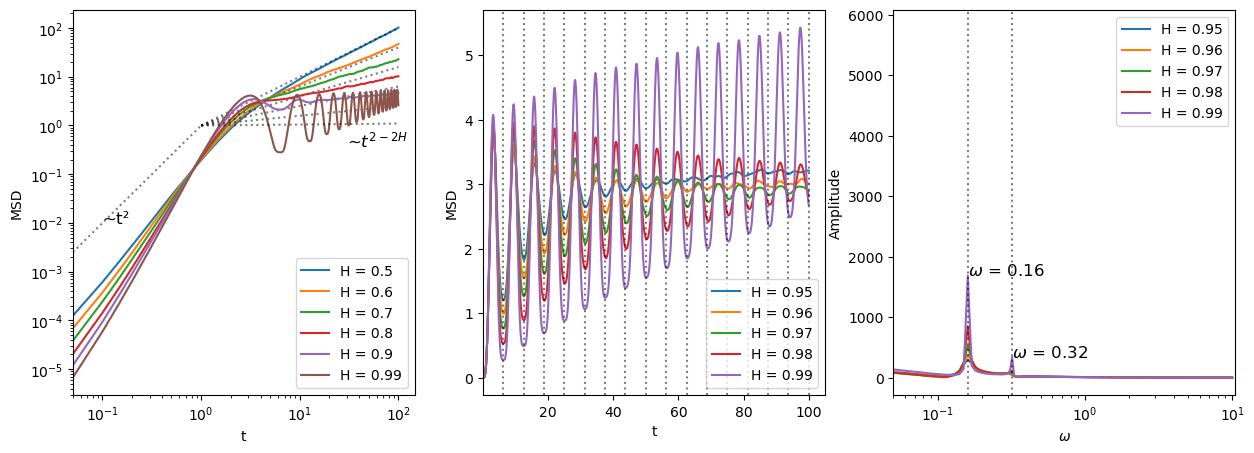

In [12]:
avg = 4000

task_set = ["001"] 
A = 1.0
eta = 1.0
C = 0.0
theta_H = 1.0
theta_12 = 0.0
x0i = 1
fig, ax = plt.subplots(1,3, figsize = (15,5))

#TREND

H = 0.50001
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
plot_msd(ax[0], df_msd, H)
add_trend(ax[0], x0 = x0i, xf = 100, func = t2_2H, text = r"", xtext = 0.1, H = H)

H = 0.6
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
plot_msd(ax[0], df_msd, H)
add_trend(ax[0], x0 = x0i, xf = 100, func = t2_2H, text = r"", xtext = 0.1, H = H)

H = 0.7
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
plot_msd(ax[0], df_msd, H)
add_trend(ax[0], x0 = x0i, xf = 100, func = t2_2H, text = r"", xtext = 0.1, H = H)

H = 0.8
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
plot_msd(ax[0], df_msd, H)
add_trend(ax[0], x0 = x0i, xf = 100, func = t2_2H, text = r"", xtext = 0.1, H = H)

H = 0.9
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
plot_msd(ax[0], df_msd, H)
add_trend(ax[0], x0 = x0i, xf = 100, func = t2_2H, text = r"", xtext = 0.1, H = H)

H = 0.99
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
plot_msd(ax[0], df_msd, H)
add_trend(ax[0], x0 = 1, xf = 100, func = t2_2H, text = r"~$t^{2-2H}$", xtext = 30, dy = -0.7, H = H)

ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlim(xmin = h)

add_trend(ax[0], x0 = h, xf = 1, func = t2, text = "~t²", xtext = 0.1)

#OSCILATIONS
avg = 12000

task_set = ["001", "002"] 

H = 0.95
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
df_ft = get_ft(df_msd, h, T)
df_freq = get_freq(df_ft)
plot_msd(ax[1], df_msd, H)
plot_fft(ax[2], df_ft, H)

H = 0.96
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
df_ft = get_ft(df_msd, h, T)
df_freq = get_freq(df_ft)
plot_msd(ax[1], df_msd, H)
plot_fft(ax[2], df_ft, H)

H = 0.97
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
df_ft = get_ft(df_msd, h, T)
df_freq = get_freq(df_ft)
plot_msd(ax[1], df_msd, H)
plot_fft(ax[2], df_ft, H)

H = 0.98
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
df_ft = get_ft(df_msd, h, T)
df_freq = get_freq(df_ft)
plot_msd(ax[1], df_msd, H)
plot_fft(ax[2], df_ft, H)

H = 0.99
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
df_ft = get_ft(df_msd, h, T)
df_freq = get_freq(df_ft)
plot_msd(ax[1], df_msd, H)
plot_fft(ax[2], df_ft, H)
add_freq(ax[2], df_freq)


add_freq_grid(ax[1], df_freq.iloc[0].fr, T)

ax[1].set_xlim(xmin = h)
ax[2].set_xlim(xmin = h)
ax[2].set_xscale("log")
fig.savefig("../outs/lutz.png", dpi = 200)

## TIME GLASS

$  A \frac{dq^2}{dt^2} + \eta \space {}^{C}_{O}D^{\beta}_{t}q(t) =  \theta_{1/2}\xi_{1/2}$

Time glass: $C = 0$, $\theta_H = 0$

* Order of the dervative: $\beta \in [0.05, 0.1]$. 
* Hurst: $\beta = 2 - 2H$, $H \in [0.95, 0.975]$

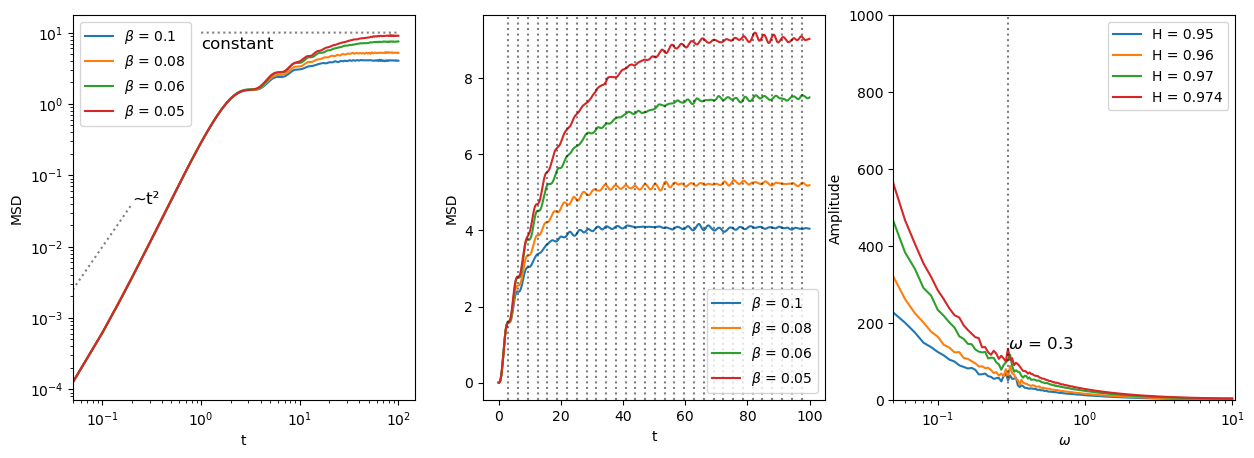

In [11]:
A = 1.0
eta = 1.0
C = 0.0
theta_H = 0.0
theta_12 = 1.0

task_set = ["001", "002"]

fig, ax = plt.subplots(1,3, figsize = (15,5))

H = 0.95
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
df_ft = get_ft(df_msd, h, T)
df_freq = get_freq(df_ft)
plot_msd(ax[0], df_msd, H, log = True, beta = True)
plot_msd(ax[1], df_msd, H, beta = True)
plot_fft(ax[2], df_ft, H)


H = 0.96
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
df_ft = get_ft(df_msd, h, T)
df_freq = get_freq(df_ft)
plot_msd(ax[0], df_msd, H, log = True, beta = True)
plot_msd(ax[1], df_msd, H, beta = True)
plot_fft(ax[2], df_ft, H)

H = 0.97
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
df_ft = get_ft(df_msd, h, T)
df_freq = get_freq(df_ft)
plot_msd(ax[0], df_msd, H, log = True, beta = True)
plot_msd(ax[1], df_msd, H, beta = True)
plot_fft(ax[2], df_ft, H)

H = 0.974
df_msd = get_msd(A, eta, C, theta_12, theta_H, H, avg, h, task_set)
df_ft = get_ft(df_msd, h, T)
df_freq = get_freq(df_ft,0.975).tail(1)
plot_msd(ax[0], df_msd, H, log = True, beta = True)
plot_msd(ax[1], df_msd, H, beta = True)
plot_fft(ax[2], df_ft, H)

add_trend(ax[0], x0 = h, xf = 0.2, func = t2, text = "~t²", xtext = 0.2)
add_trend(ax[0], x0 = 1, xf = 100, func = constant, text = "constant", xtext = 1, dy = -4)

add_freq(ax[2], df_freq, dy = 150)
add_freq_grid(ax[1], 1/np.pi, T)#df_freq.iloc[2].fr, T)

ax[0].set_xlim(xmin = h)
ax[2].set_xlim(xmin = h)
ax[2].set_ylim(ymin = 0, ymax = 1000)
ax[2].set_xscale("log")
fig.savefig("../outs/time-glass.png", dpi = 200)